# Detecting Mental Clues Remotely - Working Paper
by Ivan Liu, Fangyuan Liu, Qi Zhong, Shiguang Ni 

## Environment Preparation

In [2]:
#Commonly Used Packages
import sys
sys.path.insert(0, sys.path[0]+"/../")
import os
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import mmer.remote_ppg
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp


## Figure 1

In [3]:
from mmer.remote_ppg import visualization as vis
feature = vis.Feature()

# face for demonstration
file_name = './resources/images/face_example.jpg'

# Out of the 468 facial regions of interest (ROI) defined in MediaPipe (Google Inc),
# we chose 70 points away from the edges of the face and the lips.
landmarks_list = [3, 4, 5, 6, 8, 9, 10, 18, 32, 36, 43, 48, 50, 67, 69, 92, 101, 103, 104, 108, 109, 123, 134, 135, 142, 151, 164, 167, 182, 187, 192, 197, 201, 205, 206, 207, 210, 211, 212, 216, 248, 262, 266, 273, 278, 280, 297, 299, 322, 330, 332, 333, 337, 338, 352,  363, 364, 371, 393, 406, 411, 416, 421, 425, 426, 427, 430,431, 432, 436]

# Draw interactive graph.
# This graph is not included in the publication
fig = feature.get_face_with_feature_points(file_name,landmarks_list)
fig.show()

## Remote PPG Demo

The following codes demonstrate how to convert videos into blood volumn pulse chart. We use this demostration instead the actual raw data used in our experiment to protect the privacy of our research participants.



### Convert Videos to Beat Per Minute (BPM) Data

This step demonstrate how we convert video files into heart beats per minute (BPM) data

In [3]:
sys.path.insert(0, sys.path[0]+"/../")
from mmer.remote_ppg import process as prc # remote PPG video process using pyVHR 
v = prc.Video()

In [7]:
r_ppg_video_source_folder_path = './resources/videos/' 
r_ppg_video_bpm_results_folder_path = './results/remote_ppg_demo/'

# Extract features from films and convert them into beat per minute data.
# This step takes about 10 minutes for each 2-minute film
bpm_output_folder = v.convert_sig_to_bpm(r_ppg_video_source_folder_path, r_ppg_video_bpm_results_folder_path, landmarks_list)

### Show one of the BPM chart.

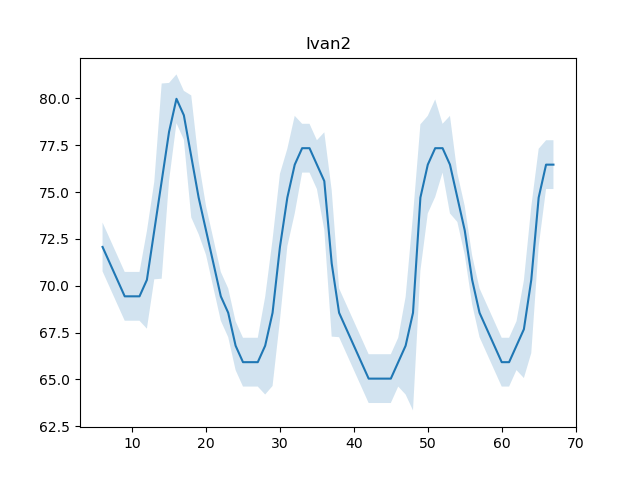

### Convert BPM data To HRV

In [ ]:
import sys
sys.path.insert(0, sys.path[0]+"/../")
from mmer.cardio import hrv as crv
r_ppg_video_bpm_results_folder_path = './results/remote_ppg_demo/'
BPM_folder_path = os.path.join(r_ppg_video_bpm_results_folder_path, "bpm_output")
hrv = crv.hrv()
result = hrv.convert_bpm_to_hrv(BPM_folder_path)

## Figure 3

### Referencing r-PPG to ECG

Since the data used in this example is the raw material without filtering out outliers or errors, the results of this demonstration is not exactly the same as the results used in the article.

In [198]:
import os
import sys
import pandas as pd
sys.path.insert(0, sys.path[0]+"/../")
from mmer.remote_ppg import visualization as vis
import mmer.utility.preprocessing as pre
compare = vis.Comparison()

ecg_file_path = './resources/data/comparison/ecg.csv'
r_ppg_file_path = './resources/data/comparison/ppg.csv'
column_names = ['HR','rMSSD','pNN50','SDNN',"ln(HF)","ln(LF)"]
df_ecg = pd.read_csv(ecg_file_path)
df_r_ppg = pd.read_csv(r_ppg_file_path)
rows_r = []
rows_p = []
rows_n = []

for j in range(10):
    df_1 = df_ecg.copy()
    df_2 = df_r_ppg.copy()
    df_2 = df_2[df_2["MAD_HR"]<0.3+0.02*j]
    df_1 = df_1.reset_index(drop=True)
    df_2 = df_2.reset_index(drop=True)

    df_new_1 = pd.DataFrame()
    df_new_2 = pd.DataFrame()
    for index in range(len(df_1["ID"])):
        row = df_2.loc[df_2['ID'] == df_1["ID"][index]]
        if len(row)>0:
            df_new_1 = pd.concat([df_new_1,df_1.loc[index]],axis=1,ignore_index=True)
            df_new_2 = pd.concat([df_new_2,row.iloc[0]],axis=1,ignore_index=True)  # 如果存在两条及以上的切片，则取前2分钟的值
    df_new_1 = df_new_1.transpose()  # 转置
    df_new_2 = df_new_2.transpose()
    row_r = np.zeros(len(column_names))
    row_p = np.zeros(len(column_names))
    row_n = np.zeros(len(column_names))

    for i in range(len(column_names)):
        row_r[i] = pearsonr(df_new_1[column_names[i]],df_new_2[column_names[i]])[0]
        row_p[i] = pearsonr(df_new_1[column_names[i]],df_new_2[column_names[i]])[1]
        row_n[i] = len(df_new_1)
    rows_r.append(row_r)
    rows_p.append(row_p)
    rows_n.append(row_n)

print(pd.DataFrame(rows_r))
print(pd.DataFrame(rows_p))
print(pd.DataFrame(rows_n))

          0         1         2         3         4         5
0  0.968872  0.491107  0.473081  0.599936  0.182860  0.108727
1  0.959654  0.425088  0.407556  0.469041  0.178055  0.079910
2  0.943871  0.394529  0.275212  0.550380  0.064612  0.138376
3  0.908575  0.262771  0.198233  0.428232  0.048736  0.137694
4  0.856700  0.258506  0.247761  0.350903  0.054942  0.138602
5  0.850684  0.248867  0.258898  0.323424  0.064586  0.146982
6  0.855605  0.243902  0.246727  0.324731  0.028936  0.140991
7  0.851285  0.209531  0.211735  0.323521  0.004445  0.158848
8  0.840046  0.201932  0.192819  0.305409 -0.009505  0.151150
9  0.840208  0.195743  0.190099  0.304713 -0.008480  0.149059
              0         1         2             3         4         5
0  1.799582e-37  0.000059  0.000118  3.225041e-07  0.158374  0.404226
1  1.310321e-48  0.000041  0.000089  4.597903e-06  0.098947  0.461882
2  1.227966e-57  0.000010  0.002560  1.072688e-10  0.486982  0.135084
3  8.772639e-62  0.000788  0.011978  1

In [189]:
df_r_ppg_2 = df_r_ppg[df_r_ppg["MAD_HR"]<0.42].copy()
df_r_ppg_2 = df_r_ppg_2.reset_index(drop=True)
compare.compare_two_data_frame(df_ecg,df_r_ppg_2,column_names)

## Thermal Imaging Demo

來源 https://github.com/IS2AI/thermal-facial-landmarks-detection


安裝dlib要用conda install -c conda-forge dlib 參考:https://pyimagesearch.com/2018/01/22/install-dlib-easy-complete-guide/


USAGE 

python dlib_predict_video.py --input video/2_0.avi --models  models/ --upsample 1 --output demo/output.mp4

[INFO] loading dlib thermal face detector...
[INFO] loading facial landmark predictor...
[INFO] Processing video: 1/1
participant
c:\Working\Programming\Github\ResearchToolbox\ResearchToolbox\example\paper1\./result/thermal/csv_output/participant.csv
finished


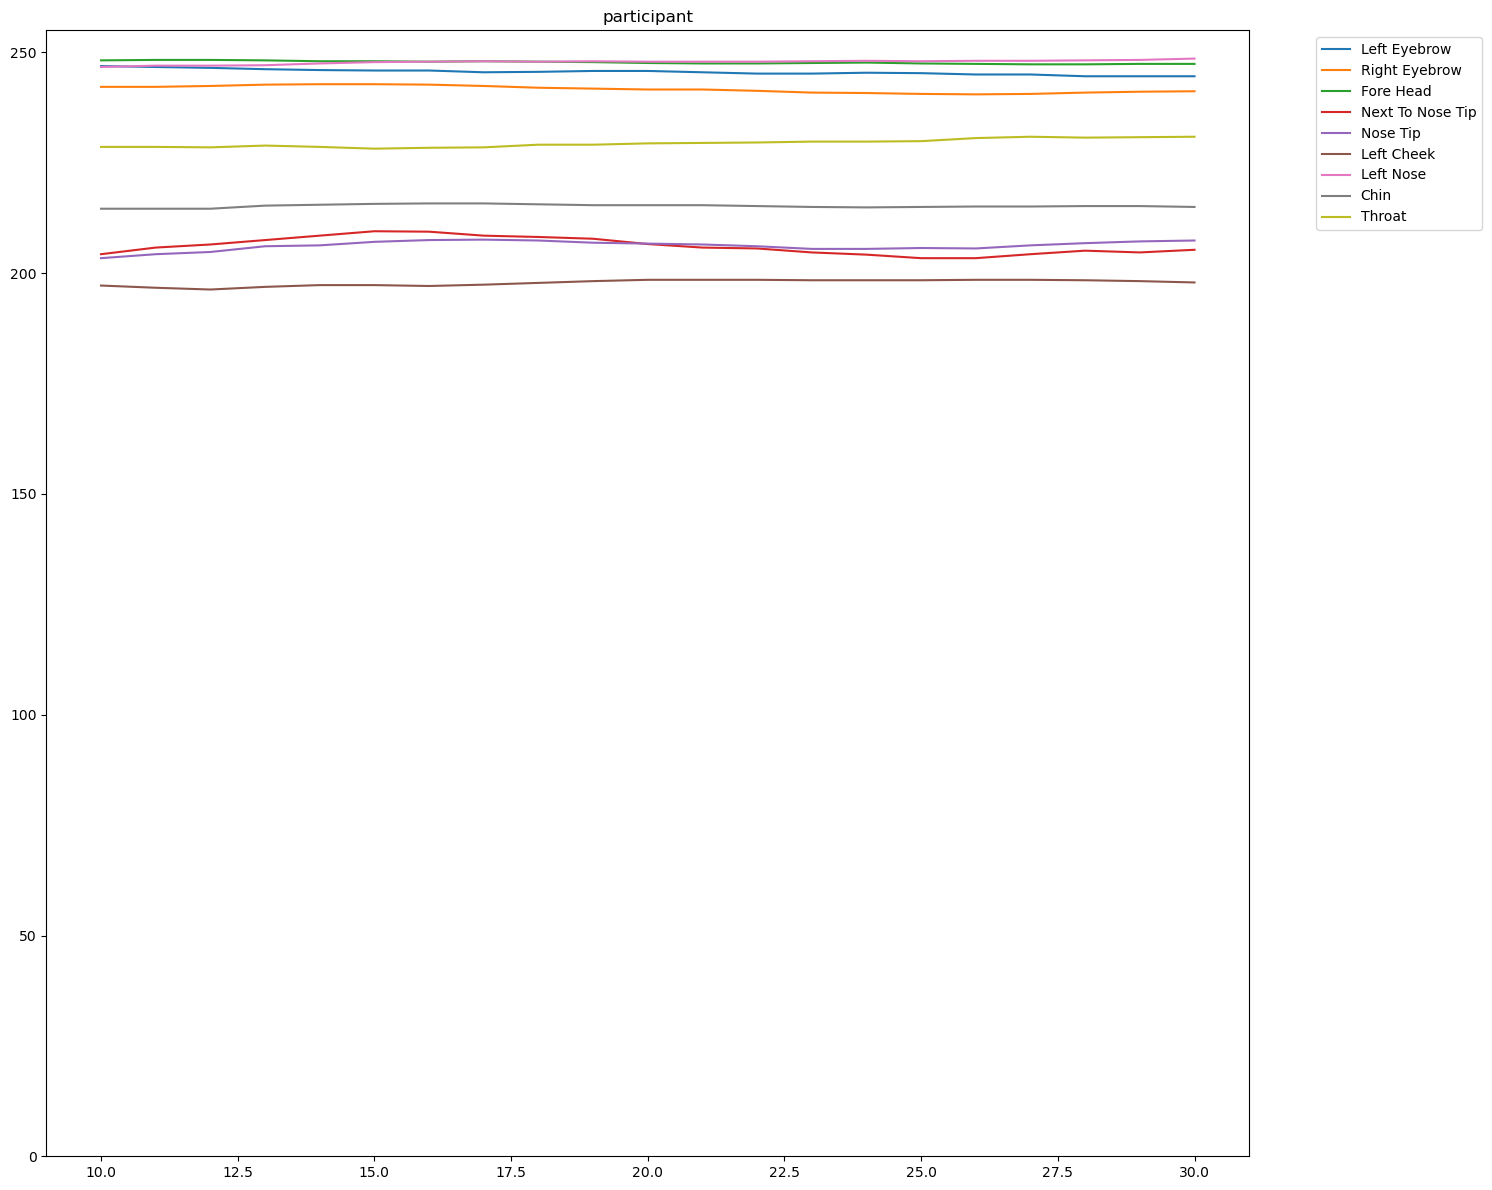

<Figure size 1500x1200 with 0 Axes>

In [10]:
import sys
sys.path.insert(0, sys.path[0]+"/../")
import numpy as np
from mmer.thermal_imaging import features_extraction as fe

input_file_path = "./resources/thermal/"  # 实际上是视频
model_path = "./resources/models/"
output_file_path = "./result/thermal/"
upsampling_times = 1
n_feature_points = 54+7  # 臉部特徵點的數量
n_sampling = 30  # downsampling
adaptive_length = np.int16(30*10/n_sampling)  # 多少禎以後，限制數值變化的範圍
resize_height = 600  # 調整影像的大小。600時，大概每秒可以處理1禎，但是如果下降到300，只需要1/100的時間。不過，識別正確性會減低。
height_lower_threshold = np.int16(resize_height*0.2)
height_upper_threshold = np.int16(resize_height*0.8)
x_average = 0
y_average = 0
minimum_gray_color = 30  # 設一個最低的值,以避免抓到奇怪的數值

para_dict = {
    "n_feature_points": n_feature_points,
    "n_sampling": n_sampling,
    "resize_height": resize_height,
    "upsampling_times": upsampling_times,
    "minimum_gray_color": minimum_gray_color
}

thermal = fe.features_extraction(model_path, input_file_path, output_file_path, para_dict)
thermal.run()


